# Part II: Model Development

In this part, we develop three unique pipelines for predicting backorder. We use the smart sample from Part I to fit and evaluate these pipelines. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools
import numpy as np
import pandas as pd
import joblib
import pickle as pkl

## Reload the smart sample here

In [3]:

# Reload your smart sampling from local file 
# ----------------------------------

sample_data, sampled_X, sampled_y = joblib.load('sample-data.pkl')
sampled_X = pd.DataFrame(sampled_X,
                        columns = ['national_inv', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
                                  'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
                                   'potential_issue', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
                                   'local_bo_qty', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'])
sampled_y = pd.DataFrame(sampled_y,
                        columns = ['went_on_backorder'])

In [4]:
dataset = sample_data

## Normalize/standardize the data if required

In [5]:
from sklearn.preprocessing import MinMaxScaler


norm = MinMaxScaler().fit(dataset)

dataset_norm = norm.transform(dataset)

# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
# names = dataset.columns
# d = scaler.fit_transform(dataset)
# scaled_dataset = pd.DataFrame(d, columns=names)
# scaled_dataset



In [6]:
norm = MinMaxScaler().fit(sampled_X)

X_norm = norm.transform(sampled_X)


# scaler = preprocessing.MinMaxScaler()
# names = sampled_X.columns
# d = scaler.fit_transform(sampled_X)
# scaled_X = pd.DataFrame(d, columns=names)
# scaled_X

In [7]:
norm = MinMaxScaler().fit(sampled_y)

y_norm = norm.transform(sampled_y)


# scaler = preprocessing.MinMaxScaler()
# names = sampled_y.columns
# d = scaler.fit_transform(sampled_y)
# scaled_y = pd.DataFrame(d, columns=names)
# scaled_y

## Split the data into Train/Test

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25) # 75% in train. 25% in test

## Developing Pipeline

In this section, we design an operationalized machine learning pipeline, which includes:

* Anomaly detection
* Dimensionality Reduction
* Train a model

We are free to use any of the models that we learned in the past or use new models. 

* It is difficult to fit an anomaly detection method in the sklearn pipeline without writing custom codes. For simplicity, we avoid fitting an anomaly detection method within a pipeline. So we can create the workflow in two steps. 
    * Step I: fit an outlier with the training set
    * Step II: define a pipeline using a feature selection and a classification method. Then cross-validate this pipeline using the training data without outliers. 
        * Note: if your smart sample is somewhat imbalanced, you might want to change the scoring method in GridSearchCV (see the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)).

* Once we fit the pipeline, we identify the best model and give an unbiased evaluation using the test set that we created in Part II. For unbiased evaluation we report confusion matrix, precision, recall, f1-score, accuracy, and other measures if you like. 

(Optional) Those who are interested in writing custom codes for adding an outlier detection method into the sklearn pipeline, please follow this discussion [thread](https://stackoverflow.com/questions/52346725/can-i-add-outlier-detection-and-removal-to-scikit-learn-pipeline). 


**Note:** <span style='background:yellow'>We will be using Grid Search to find the optimal parameters of the pipelines.</span>

You can add more notebook cells or import any Python modules as needed.

In [9]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

### Your 1st pipeline 
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation
  
Add cells as needed. 

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


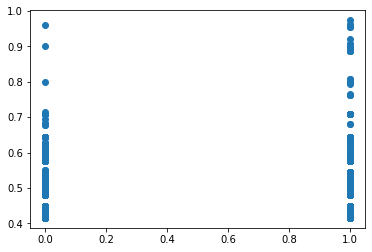

In [10]:
# Add anomaly detection code  (Question #E201)
# ----------------------------------

def elliptic_envelope_session():
    # Fit envelope
    envelope = EllipticEnvelope(support_fraction=1, contamination=0.2).fit(X_train)

    # Create an boolean indexing array to pick up outliers
    outliers = envelope.predict(X_train)==-1

    # Re-slice X,y into a cleaned dataset with outliers excluded
    X_clean = X_train[~outliers]
    y_clean = y_train[~outliers]
    return X_clean, y_clean

def fit_plot(dataset_clean):
    # Unpack cleaned dataset
    X_clean, y_clean = dataset_clean
    
    # Assuming we have our set of inliers in X_clean we can re-fit
    model = Ridge().fit(X_clean, y_clean)
    y_pred = model.predict(X_clean)
    
    # Plot the regression
    plt.scatter(y_clean, y_pred)
    plt.show()
    
    # Not sure if this plot is correct, but plotting X_clean to y_pred would not work. Vaibhav suggested it is probably due to
    # the features that X and y has
    
    
fit_plot(elliptic_envelope_session())


In [11]:
# Add codes for feature selection and classification pipeline with grid search  (Question #E202)
# ----------------------------------
from sklearn.linear_model import LogisticRegression


pipe1 = Pipeline([
    ('PCA', PCA(n_components= 5)),
    ('logistic', LogisticRegression())
])



In [12]:
param_grid = {'logistic__C': [5,10,15,20,25],
              'logistic__max_iter': [10000],
              'PCA__n_components': [5,10,15,20,25],}

from sklearn.model_selection import GridSearchCV

model_grid = GridSearchCV(pipe1, param_grid, cv=10, n_jobs=2)

X_clean, y_clean = elliptic_envelope_session()

model_grid.fit(X_clean, y_clean)

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.53420398 0.53420398 0.53420398 0.53420398 0.53420398 0.53885304
 0.53996005 0.54438837 0.54881745 0.5466775  0.53877924 0.54003385
 0.54468357 0.54911265 0.54682494 0.53877924 0.54003385 0.54453597
 0.54918645 0.5468251         nan        nan        nan        nan
        nan]
  category=UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=5)),
                                       ('logistic', LogisticRegression())]),
             n_jobs=2,
             param_grid={'PCA__n_components': [5, 10, 15, 20, 25],
                         'logistic__C': [5, 10, 15, 20, 25],
                         'logistic__max_iter': [10000]})

In [13]:
model_grid.cv_results_

{'mean_fit_time': array([0.09384007, 0.10490918, 0.10215898, 0.11126251, 0.09720294,
        0.16200893, 0.20154545, 0.19779756, 0.2084378 , 0.20102181,
        0.15235875, 0.20121632, 0.20134435, 0.20139601, 0.20574262,
        0.12874146, 0.15953608, 0.17437341, 0.1789259 , 0.16813796,
        0.00144482, 0.00143318, 0.00375059, 0.00137656, 0.00138333]),
 'std_fit_time': array([0.01188076, 0.01286824, 0.00415296, 0.0154047 , 0.00564642,
        0.01867147, 0.00733506, 0.02655094, 0.02551666, 0.02149916,
        0.02361322, 0.00865271, 0.00952672, 0.02825501, 0.01898324,
        0.0251892 , 0.03029606, 0.02272778, 0.02328624, 0.02103701,
        0.00013665, 0.0001303 , 0.00724511, 0.00010236, 0.00013009]),
 'mean_score_time': array([0.00087419, 0.00089991, 0.00089161, 0.00090389, 0.00086005,
        0.0009445 , 0.00093122, 0.00084987, 0.00087039, 0.00087564,
        0.00090916, 0.00097492, 0.00088077, 0.00090027, 0.00094445,
        0.00095417, 0.0009027 , 0.00094466, 0.00098879, 0.00

In [14]:
# Given an unbiased evaluation  (Question #E203)
# ----------------------------------
from sklearn.metrics import classification_report, confusion_matrix


predicted_y = model_grid.predict(X_test)

pd.DataFrame(confusion_matrix(y_test, predicted_y))

,0,1
0,1116,1786
1,826,1919


In [15]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

         0.0       0.57      0.38      0.46      2902
         1.0       0.52      0.70      0.60      2745

    accuracy                           0.54      5647
   macro avg       0.55      0.54      0.53      5647
weighted avg       0.55      0.54      0.53      5647



#### <center>Record the optimal hyperparameters and performance resulting from this pipeline.</center>

In [16]:
model_grid.best_params_

{'PCA__n_components': 20, 'logistic__C': 20, 'logistic__max_iter': 10000}

In [17]:
model_grid.best_index_

18

In [18]:
model_grid.cv_results_['mean_test_score'][7]

0.5443883682199654

In [19]:
model_grid.cv_results_['std_test_score'][7]

0.010289089556138284

## <span style="background: yellow;">Commit your code!</span> 

### Your 2nd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

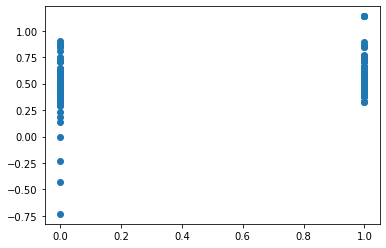

In [20]:
# Add anomaly detection code  (Question #E205)
# ----------------------------------
from sklearn.cluster import KMeans

def kmeans_session():
    # run k-means clustering
    km_clusters = KMeans(n_clusters=3, algorithm="full").fit_predict(X_train, y_train)
    
    # create cluster distribution, this time they are in tuples so we can sort easily
    dist_clusters = ((np.sum(km_clusters==z), z) for z in np.unique(km_clusters))
    
    # sort clusters descendingly by number of data entries in cluster
    dist_clusters = sorted(dist_clusters, reverse = True)
    
    # find out the cluster with max number of data entries
    max_cluster = dist_clusters[0][1]

    # select data in max_cluster as inliers
    inliers = km_clusters == max_cluster
    
    X_inliers = X_train[inliers]
    y_inliers = y_train[inliers]
    
    return X_inliers, y_inliers

fit_plot(kmeans_session())

In [21]:
# Add codes for feature selection and classification pipeline with grid search  (Question #E206)
# ----------------------------------
from sklearn.svm import SVC

pipe2 = Pipeline([
    ('PCA', PCA(n_components= 5)),
    ('SVC', SVC(kernel='rbf'))
])


In [22]:
from scipy.stats import uniform

param_grid2 = {'SVC__C': [100,200,300,400,500],
              'SVC__gamma': [0,1,2,3,4], 
              'PCA__n_components': [20],
              'SVC__kernel': ['rbf']}

model_grid2 = GridSearchCV(pipe2, param_grid2, cv=10, n_jobs=2)

X_inliers, y_inliers = kmeans_session()

model_grid2.fit(X_inliers, y_inliers)

#kmeans_session()

#elliptic_envelope_session()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=5)),
                                       ('SVC', SVC())]),
             n_jobs=2,
             param_grid={'PCA__n_components': [20],
                         'SVC__C': [100, 200, 300, 400, 500],
                         'SVC__gamma': [0, 1, 2, 3, 4],
                         'SVC__kernel': ['rbf']})

In [23]:
# Given an unbiased evaluation  (Question #E207)
# ----------------------------------

predicted_y2 = model_grid2.predict(X_test)

pd.DataFrame(confusion_matrix(y_test, predicted_y2))

,0,1
0,1322,1580
1,845,1900


In [24]:
print(classification_report(y_test, predicted_y2))

              precision    recall  f1-score   support

         0.0       0.61      0.46      0.52      2902
         1.0       0.55      0.69      0.61      2745

    accuracy                           0.57      5647
   macro avg       0.58      0.57      0.57      5647
weighted avg       0.58      0.57      0.56      5647



#### <center>Record the optimal hyperparameters and performance resulting from this pipeline.</center>

In [25]:
model_grid2.best_params_

{'PCA__n_components': 20, 'SVC__C': 100, 'SVC__gamma': 3, 'SVC__kernel': 'rbf'}

In [26]:
model_grid2.best_index_

3

In [27]:
model_grid2.cv_results_['mean_test_score'][7]

0.5989536861129493

In [28]:
model_grid2.cv_results_['std_test_score'][7]

0.016523224086296754

## <span style="background: yellow;">Commit your code!</span> 

### Your 3rd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

In [29]:
# Add anomaly detection code  (Question #E209)
# ----------------------------------
from sklearn.neighbors import LocalOutlierFactor

def local_outlier_factor_session():
    lof_labels = LocalOutlierFactor(n_neighbors=10).fit_predict(X_train, y_train)
    inliers = lof_labels == 1
    
    X_inliers = X_train[inliers]
    y_inliers = y_train[inliers]
    
    return X_inliers, y_inliers


In [30]:
# Add codes for feature selection and classification pipeline with grid search  (Question #E210)
# ----------------------------------
from sklearn.naive_bayes import GaussianNB


pipe3 = Pipeline([
    ('PCA', PCA(n_components= 5)),
    ('clf', GaussianNB())
])





In [31]:
param_grid3 = {
    'clf__priors': [None],
    'clf__var_smoothing': [0.001, 0.00001, 0.00000001]
}


model_grid3 = GridSearchCV(pipe3, param_grid3, cv=10, n_jobs=2)

X_inliers, y_inliers = local_outlier_factor_session()

model_grid3.fit(X_inliers, y_inliers)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=5)),
                                       ('clf', GaussianNB())]),
             n_jobs=2,
             param_grid={'clf__priors': [None],
                         'clf__var_smoothing': [0.001, 1e-05, 1e-08]})

In [32]:
# Given an unbiased evaluation  (Question #E211)
# ----------------------------------

predicted_y3 = model_grid3.predict(X_test)

pd.DataFrame(confusion_matrix(y_test, predicted_y3))

,0,1
0,2878,24
1,2693,52


In [33]:
print(classification_report(y_test, predicted_y3))

              precision    recall  f1-score   support

         0.0       0.52      0.99      0.68      2902
         1.0       0.68      0.02      0.04      2745

    accuracy                           0.52      5647
   macro avg       0.60      0.51      0.36      5647
weighted avg       0.60      0.52      0.37      5647



In [34]:
model_grid3.best_params_

{'clf__priors': None, 'clf__var_smoothing': 1e-08}

In [35]:
model_grid3.best_index_

2

In [36]:
model_grid2.cv_results_['mean_test_score'][2]

0.5927989696956759

In [37]:
model_grid2.cv_results_['std_test_score'][2]

0.009976148590729858

#### <center>Record the optimal hyperparameters and performance resulting from this pipeline.</center>

## Compare these three pipelines and discuss your findings

## <span style="background: yellow;">Commit your code!</span> 

### Pickle the required pipeline/models for Part III.

In [38]:

joblib.dump([pipe1, model_grid, pipe2, model_grid2, pipe3, model_grid3], 'pipelines.pkl')


['pipelines.pkl']

You should have made a few commits so far of this project.  
**Definitely make a commit of the notebook now!**  
Comment should be: `Final Project, Checkpoint - Pipelines done`


# Save your notebook!
## Then `File > Close and Halt`